# TODO


 1. Ensure that the point wkt and the line wkt are in the same projection. 
    - ~~Probably need to reproject the point wkt to epsg 4269 and update the metadata accordingly~~
    - They are the same! Need to update the proj4 string and crs_wkt to be more clear.
 2. Pull as many relevant attributes from the NHD geodatabase as needed, put them into the spatial index netcdf file.
 3. Build those attributes into the NDHSpatialIndex classes

In [1]:
import xarray as xr
import shapely.wkt
import pandas as pd
import numpy as np
import pathlib as pl

In [37]:
sp_idx_path = pl.Path('data/nwm-v1.2-channel_spatial_index_w_attrs.nc')
comid = 4512772 # some small segment on the Potomac near DC

In [126]:
ds = xr.open_dataset(sp_idx_path) #, chunks={'feature_id': 10}) for dask... not necessary right now
ds

<xarray.Dataset>
Dimensions:     (feature_id: 2729077)
Coordinates:
  * feature_id  (feature_id) int64 101 179 181 ... 932040360 947080027 948060094
Data variables:
    latitude    (feature_id) float64 ...
    longitude   (feature_id) float64 ...
    ST          (feature_id) object ...
    CNTY        (feature_id) object ...
    pt_wkt      (feature_id) object ...
    line_wkt    (feature_id) object ...
Attributes:
    proj4:                +proj=longlat +datum=NAD83 +no_defs
    esri_pe_string:       GEOGCS[GCS_North_American_1983,DATUM[D_North_Americ...
    model_version:        NWM 1.2
    Conventions:          CF-1.6
    cdm_datatype:         Station
    station_dimension:    feature_id
    stream_order_output:  1

In [121]:
ds.esri_pe_string

'GEOGCS[GCS_North_American_1983,DATUM[D_North_American_1983,SPHEROID[GRS_1980,6378137.0,298.257222101]],PRIMEM[Greenwich,0.0],UNIT[Degree,0.017453292519943295]]'

In [123]:
x = 'GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]'
x

'GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4269"]]'

In [115]:
class NHDSpatialIndex:
    def __init__(self):
        
        ## This will change to the location on GCS when the netcdf file is made public
        self.__ds_path = pl.Path('data/nwm-v1.2-channel_spatial_index_w_attrs.nc')
        self.__ds = xr.open_dataset(sp_idx_path)
        
    @property
    def ds_path(self):
        """The path of the underlying NetCDF."""
        return self.__ds_path
    
    @property
    def ds(self):
        """Provides access to the underlying xarray Dataset."""
        return self.__ds
    
    @property
    def crs_proj4(self):
        return self.__ds.proj4
    
    @property
    def crs_wkt(self):
        return self.__ds.esri_pe_string
    
    def __len__(self):
        """Length of the object is set to the number of comids in the ds."""
        return len(ds[list(ds.coords)[0]])
    
    def get_comid_ds(self, comid):
        return SpatialComID(comid, self.__ds)
    
    
class SpatialComID:
    def __init__(self, comid, sp_idx_ds):
        self.__comid = comid
        self.__ds = sp_idx_ds.sel(feature_id=comid)
        
    @property
    def comid(self):
        return self.__comid
    
    @property
    def ds(self):
        return self.__ds

    @property
    def line(self):
        return shapely.wkt.loads(str(self.__ds['line_wkt'].values))
    
    @property
    def representative_pt(self):
        return shapely.wkt.loads(str(self.__ds['pt_wkt'].values))
    
    @property
    def state_fips(self):
        return str(self.__ds.ST.values)
    
    @property
    def county_fips(self):
        return str(self.__ds.CNTY.values)
    
    @property
    def lat(self):
        return float(self.__ds.latitude) 
    
    @property
    def lon(self):
        return float(self.__ds.longitude) 

In [116]:
test = NHDSpatialIndex()

In [117]:
hmm = test.get_comid_ds(comid)

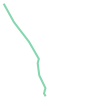

In [118]:
hmm.line

In [119]:
hmm.county_fips

'24031'

In [120]:
hmm.lat

38.948184967041016

In [66]:
list(ds.coords)[0]

'feature_id'